In [2]:
!pip install torch-lr-finder

In [3]:
!pip install split-folders

In [43]:
import os
import torch
import pandas as pd
import random
import seaborn as sns
from PIL import Image


from torch.utils.data import WeightedRandomSampler
from torch_lr_finder import LRFinder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CyclicLR
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
from torch.optim import Adam
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix

import splitfolders
import torch.optim as optim 
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [88]:
data_dir = r'E:\Jupyter\Samples\FSamples'

In [89]:
class_labels = ['Cercospora', 'No Disease', 'Abiotic', 'Leaf Rust', 'Lichens', 'Sooty Mold', 'Wilt']

In [90]:
def pad_image(image):
    # Get the dimensions of the image
    width, height = image.size

    # Find the longer side
    max_dim = max(width, height)

    # Create a square background image
    background = Image.new('RGB', (max_dim, max_dim), (255, 255, 255))

    # Calculate the position to paste the original image on the background
    pos = ((max_dim - width) // 2, (max_dim - height) // 2)

    # Paste the original image on the background
    background.paste(image, pos)

    return background

In [91]:
# Image pre-process/Image augmentation
data_transforms = transforms.Compose([
    transforms.Resize(size=(512, 512)),
    transforms.CenterCrop(448),  
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [92]:
class CoffeeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label_idx, label in enumerate(class_labels):
            class_dir = os.path.join(root_dir, label)
            if os.path.isdir(class_dir):
                for img_path in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_path)
                    self.image_paths.append(img_path)
                    label_vector = [0]*len(class_labels)
                    label_vector[label_idx] = 1
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert('RGB')
        
        img = pad_image(img)
        
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label)


In [93]:
dataset = CoffeeDataset(data_dir, transform=data_transforms)

In [94]:
splitfolders.ratio("E:\Jupyter\Samples\FSamples",
            output="splitted_data",
            seed=42,
            ratio=(.7, .2, .1),
            group_prefix=None,
            move=False)

Copying files: 1358 files [00:08, 153.57 files/s]


In [95]:
train = datasets.ImageFolder(root="/Jupyter/ML/splitted_data/train",
                              transform=data_transforms)

val = datasets.ImageFolder(root="/Jupyter/ML/splitted_data/val",
                              transform=data_transforms)

test = datasets.ImageFolder(root="/Jupyter/ML/splitted_data/test",
                              transform=data_transforms)

# -------- Getting the Whole Dataset for Visualization Purposes --------
data = datasets.ImageFolder(root="E:\Jupyter\Samples\FSamples",
                              transform=data_transforms)

In [96]:
print("Dataset Labels:\n", train.class_to_idx, "\n")

for name, dataset in zip(["TRAIN", "VALIDATION", "TEST"], [train, val, test]):
    images_per_class = pd.Series(dataset.targets).value_counts()
    print(f"Images per Class in {name}:")
    print(images_per_class, "\n")

Dataset Labels:
 {'Abiotic': 0, 'Cercospora': 1, 'Leaf Rust': 2, 'Lichens': 3, 'No Disease': 4, 'Sooty Mold': 5, 'Wilt': 6} 

Images per Class in TRAIN:
2    438
1    320
3    127
5     91
6     74
4     58
0     37
Name: count, dtype: int64 

Images per Class in VALIDATION:
2    124
1     91
3     36
5     26
6     21
4     16
0     10
Name: count, dtype: int64 

Images per Class in TEST:
2    65
1    47
3    19
5    13
6    11
4    10
0     7
Name: count, dtype: int64 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

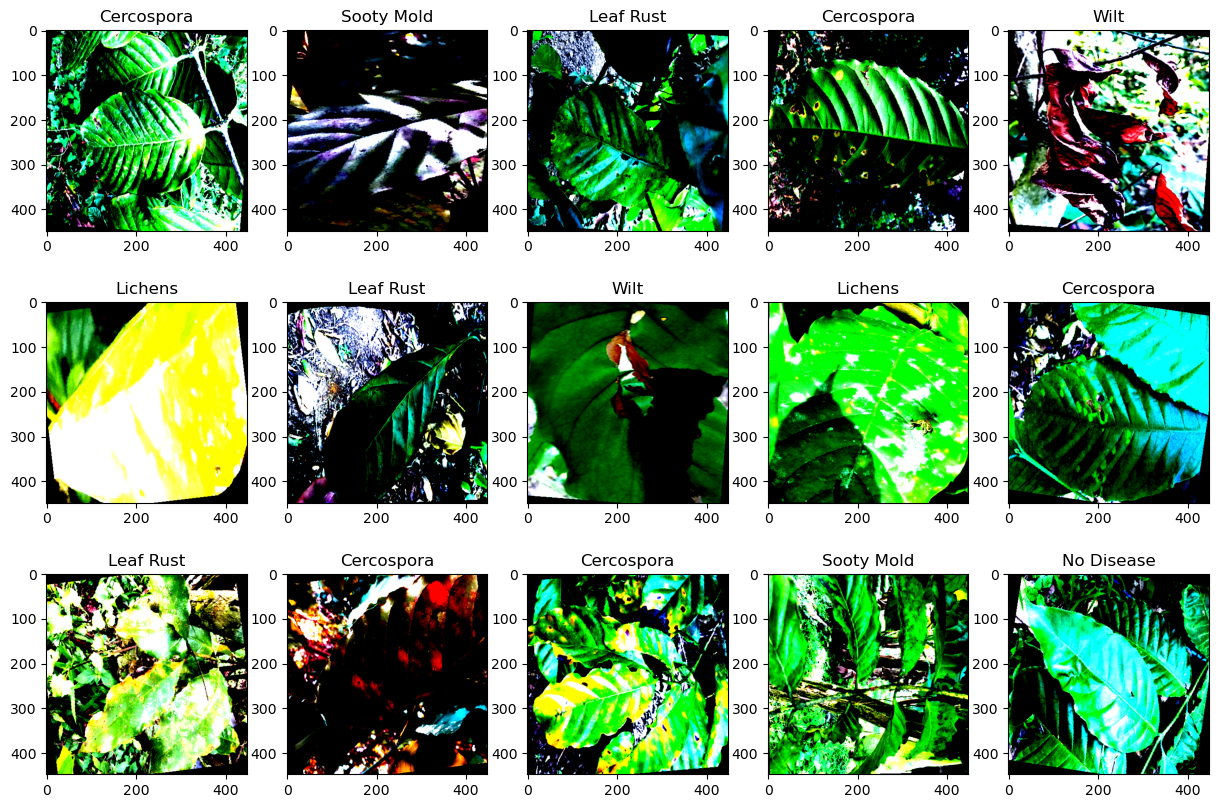

In [97]:
labels_for_viz = {v: k for k, v in data.class_to_idx.items()}

fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
for i in range(15):
    sample = random.randint(0, len(data) - 1)
    ax[i].imshow(data[sample][0].permute(1, 2, 0))
    ax[i].title.set_text(labels_for_viz[data[sample][1]])

In [54]:
train_loader = DataLoader(dataset=train,
                             batch_size=32,
                             num_workers=2,
                             shuffle=True)

val_loader = DataLoader(dataset=val,
                             batch_size=32,
                             num_workers=2,
                             shuffle=True)

test_loader = DataLoader(dataset=test,
                             batch_size=32,
                             num_workers=2,
                             shuffle=False)

In [55]:
print("Length of training dataset:", len(train))
print("Length of validation dataset:", len(val))
print("Length of test dataset:", len(test))

Length of training dataset: 905
Length of validation dataset: 256
Length of test dataset: 136


In [56]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Using cache found in C:\Users\Nicko/.cache\torch\hub\pytorch_vision_v0.10.0


In [57]:
resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

In [58]:
num_ftrs = resnet.fc.in_features
num_classes = len(class_labels) 
resnet.fc = nn.Linear(num_ftrs, num_classes)

In [59]:
# Create the CNN model
model = resnet

In [60]:
# Check for available GPUs
device = torch.device("cuda")

In [61]:
# Move the model to the GPU
model = model.to("cuda")

In [62]:
# Get the total number of samples and the number of samples per class
total_samples = 0
samples_per_class = []
for label in class_labels:
    class_dir = os.path.join(data_dir, label)
    if os.path.isdir(class_dir):
        num_samples = len(os.listdir(class_dir))
        total_samples += num_samples
        samples_per_class.append(num_samples)
        print(f"Number of images in {label}: {num_samples}")

# Calculate the class weights
class_weights = [total_samples / x for x in samples_per_class]
weights = torch.tensor(class_weights).to("cuda")

criterion = nn.BCEWithLogitsLoss(pos_weight=weights.cuda())
optimizer = optim.Adam(model.parameters(), lr=0.001)


Number of images in Cercospora: 458
Number of images in No Disease: 84
Number of images in Abiotic: 54
Number of images in Leaf Rust: 283
Number of images in Lichens: 182
Number of images in Sooty Mold: 130
Number of images in Wilt: 106


In [63]:
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

E:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [64]:
def train_model(model, criterion, optimizer, num_epochs=64, patience=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize lists for saving history
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    # Early stopping details
    early_stopping_counter = 0
    best_loss = float('inf')
    early_stop = False  # Flag to indicate if early stopping occurred

    for epoch in range(num_epochs):
        if early_stop:  # Check if early stopping occurred
            print('Breaking out of epoch loop due to early stopping.')
            break  # Break out of the epoch loop

        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        lr = optimizer.param_groups[0]['lr']
        print(f'Learning Rate: {lr}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loader:
                inputs = inputs.cuda()
                labels = labels.cuda().long()

                # Add an extra dimension to labels
                labels = torch.nn.functional.one_hot(labels, num_classes=7).float()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Calculate the number of correct predictions
                preds = outputs > 0.5
                corrects = (preds == labels).sum().item()
                running_corrects += corrects
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects / (len(data_loader.dataset) * num_classes)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save history
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

            # Check if early stopping conditions are met
            if phase == 'val':
                scheduler.step(epoch_loss)  
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                    print(f'Early stopping counter: {early_stopping_counter} out of {patience}')
                    if early_stopping_counter >= patience:
                        model.load_state_dict(best_model_wts)
                        print(f'Early stopping triggered.')
                        early_stop = True  # Set the early stopping flag
                        break  # Break out of the phase loop

    time_elapsed = time.time() - since
    print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history, time_elapsed, best_loss, best_acc

model, train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc = train_model(model, criterion, optimizer, num_epochs=64, patience=5)

torch.save(model.state_dict(), 'model.pth')

print("Training finished...\n")


Epoch 1/64
----------
Learning Rate: 0.001
train Loss: 1.3159 Acc: 0.7028
val Loss: 1.0018 Acc: 0.7478
Epoch 2/64
----------
Learning Rate: 0.001
train Loss: 0.8907 Acc: 0.8161
val Loss: 0.7660 Acc: 0.8298
Epoch 3/64
----------
Learning Rate: 0.001
train Loss: 0.7287 Acc: 0.8436
val Loss: 0.6869 Acc: 0.8555
Epoch 4/64
----------
Learning Rate: 0.001
train Loss: 0.6286 Acc: 0.8785
val Loss: 0.5742 Acc: 0.8783
Epoch 5/64
----------
Learning Rate: 0.001
train Loss: 0.5691 Acc: 0.8890
val Loss: 0.5476 Acc: 0.8828
Epoch 6/64
----------
Learning Rate: 0.001
train Loss: 0.5300 Acc: 0.8985
val Loss: 0.5107 Acc: 0.9001
Epoch 7/64
----------
Learning Rate: 0.001
train Loss: 0.5146 Acc: 0.9031
val Loss: 0.4961 Acc: 0.9035
Epoch 8/64
----------
Learning Rate: 0.001
train Loss: 0.4515 Acc: 0.9102
val Loss: 0.4685 Acc: 0.9023
Epoch 9/64
----------
Learning Rate: 0.001
train Loss: 0.4459 Acc: 0.9083
val Loss: 0.4491 Acc: 0.9263
Epoch 10/64
----------
Learning Rate: 0.001
train Loss: 0.4297 Acc: 0.915

In [65]:
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report

def test_model(model, test_loader, device, class_labels):
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            predictions = model(inputs)
            _, predicted = torch.max(predictions, 1)
            all_predictions.extend(predicted.to("cpu").numpy())
            all_labels.extend(outputs.to("cpu").numpy())

    # Convert predictions and labels to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Individual models
    models = [
        ('svm', SVC()),
        ('knn', KNeighborsClassifier()),
        ('dt', DecisionTreeClassifier()),
        ('rf', RandomForestClassifier()),
    ]

    for name, model in models:
        model.fit(all_predictions.reshape(-1, 1), all_labels)
        preds = model.predict(all_predictions.reshape(-1, 1))
        print(f"{name.upper()} Classification Report:")
        print(classification_report(all_labels, preds, target_names=class_labels, zero_division=1))

    # Voting Classifier
    voting_model = VotingClassifier(estimators=models, voting='hard')
    voting_model.fit(all_predictions.reshape(-1, 1), all_labels)
    voting_preds = voting_model.predict(all_predictions.reshape(-1, 1))
    print("Voting Classifier Classification Report:")
    print(classification_report(all_labels, voting_preds, target_names=class_labels, zero_division=1))

# Call the function to test the models
test_model(model, test_loader, device, class_labels)


SVM Classification Report:
              precision    recall  f1-score   support

  Cercospora       1.00      0.71      0.83         7
  No Disease       0.75      0.98      0.85        47
     Abiotic       0.97      1.00      0.98        29
   Leaf Rust       1.00      0.63      0.77        19
     Lichens       1.00      0.80      0.89        10
  Sooty Mold       0.78      0.54      0.64        13
        Wilt       1.00      1.00      1.00        11

    accuracy                           0.87       136
   macro avg       0.93      0.81      0.85       136
weighted avg       0.89      0.87      0.86       136

KNN Classification Report:
              precision    recall  f1-score   support

  Cercospora       1.00      0.71      0.83         7
  No Disease       0.75      0.98      0.85        47
     Abiotic       0.97      1.00      0.98        29
   Leaf Rust       1.00      0.63      0.77        19
     Lichens       1.00      0.80      0.89        10
  Sooty Mold       0.78 

In [66]:
def test_model():
    model = models.resnet50(weights = None)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 7)

    model = model.to(device)
    model.load_state_dict(torch.load("model.pth"))
    model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            predictions = model(inputs)
            _, predicted = torch.max(predictions, 1)
            all_predictions.extend(predicted.to("cpu").numpy())
            all_labels.extend(outputs.to("cpu").numpy())

    print("Test Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_labels))

    # Return a flattened array of all predictions
    return np.array(all_predictions).flatten()

# Call the function to test the model
all_preds = test_model()


Test Classification Report:
              precision    recall  f1-score   support

  Cercospora       1.00      0.71      0.83         7
  No Disease       0.75      1.00      0.85        47
     Abiotic       0.97      1.00      0.98        29
   Leaf Rust       0.92      0.58      0.71        19
     Lichens       0.90      0.90      0.90        10
  Sooty Mold       1.00      0.38      0.56        13
        Wilt       1.00      1.00      1.00        11

    accuracy                           0.86       136
   macro avg       0.93      0.80      0.83       136
weighted avg       0.89      0.86      0.85       136



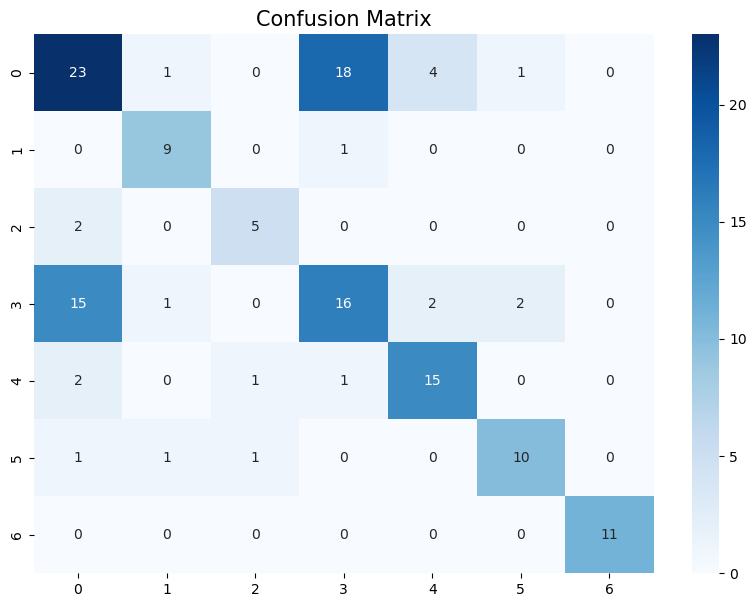

In [33]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(test.targets, all_preds), cmap="Blues", annot=True, fmt="d")
plt.title("Confusion Matrix", size=15)
plt.show()

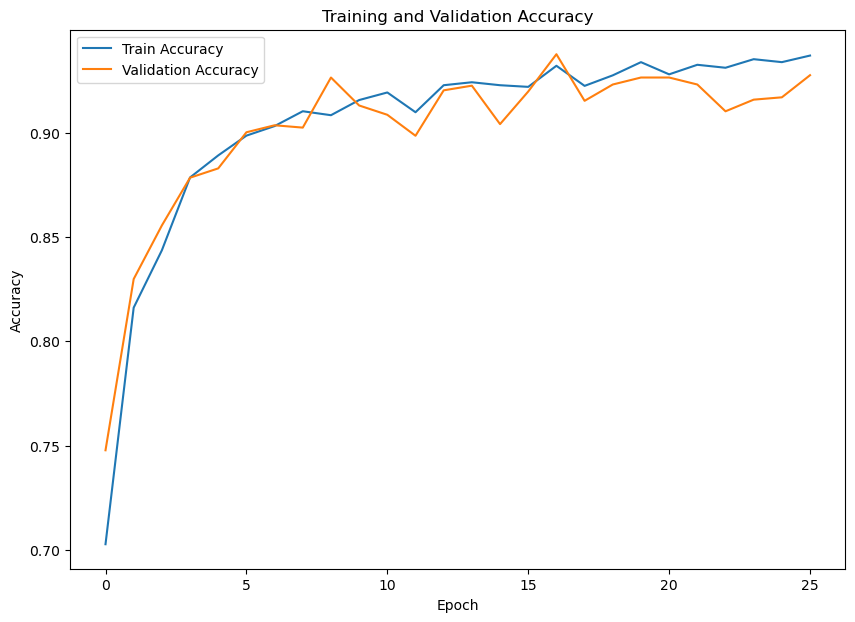

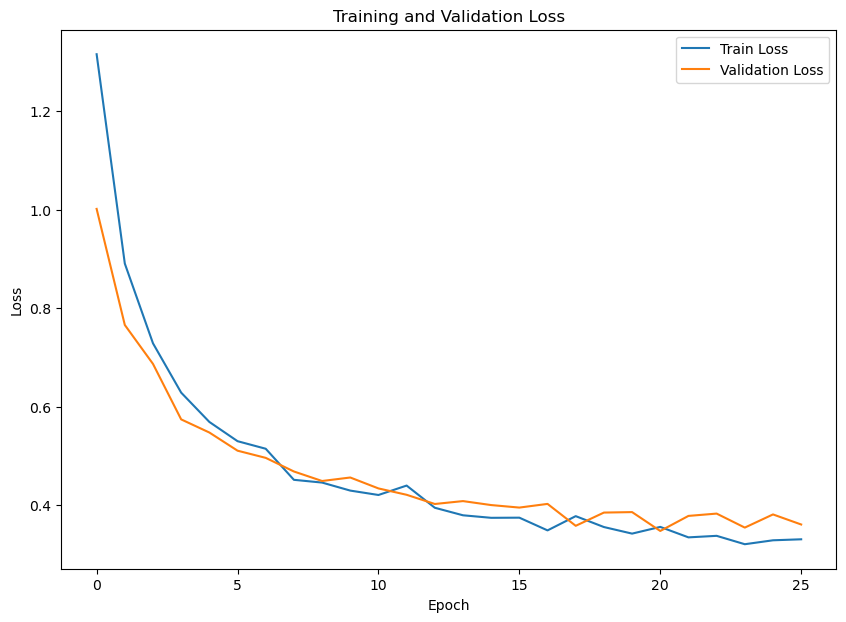

Best val Loss: 0.3477
Best val Acc: 0.9375


In [67]:
def plot_metrics(train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc):
    # Plot accuracy
    plt.figure(figsize=(10, 7))
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Print training time and best metrics
    print(f'Best val Loss: {best_loss:.4f}')
    print(f'Best val Acc: {best_acc:.4f}')

plot_metrics(train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


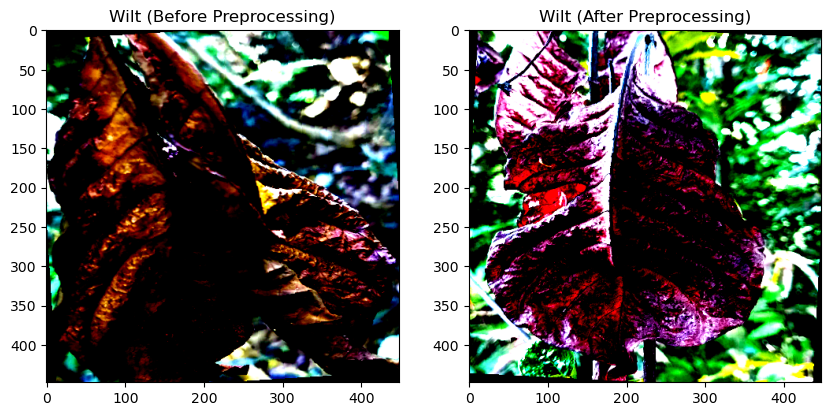

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax = ax.flatten()

ax[0].imshow(data[-1][0].permute(1, 2, 0))
ax[0].title.set_text(f"{labels_for_viz[data[-1][1]]} (Before Preprocessing)")

ax[1].imshow(test[-1][0].permute(1, 2, 0))
ax[1].title.set_text(f"{labels_for_viz[test[-1][1]]} (After Preprocessing)")
plt.show()

In [112]:
# Initialize the model
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
num_classes = len(class_labels) 
model.fc = nn.Linear(num_ftrs, num_classes)

# Load the saved parameters
model.load_state_dict(torch.load('model.pth'))
model = model.cuda()
# Don't forget to set the model to evaluation mode if you're doing inference
model.eval()

# Define the prediction function
def predict_image(image_path, model, threshold=0.6):
    image = Image.open(image_path)
    image = data_transforms(image).unsqueeze(0)
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        # Get the probabilities from the outputs
        probs = torch.sigmoid(output)
        # Apply a threshold
        preds = probs > threshold
        # Get the indices of the positive predictions
        positive_indices = [i for i, x in enumerate(preds[0]) if x]
        # Return the corresponding class labels
        return [class_labels[i] for i in positive_indices]

# Use the prediction function
image_path = "E:\Jupyter\ML\ValidationSamples\CLR (20).jpg"  
print("Predicted Class: ", predict_image(image_path, model))

Predicted Class:  ['No Disease', 'Lichens']
